Mean-variance scaling is an important difference between the normal distribution (and lognormal) and the other distributions. The normal distribution is defined by two parameters, the mean and the variance, which means the variability in the data can be big or small independent of the mean. In contrast, when we start to model data with other distributions, we’ll have to pay attention to whether the relationship between the mean and variance is correctly modeled. This is important because modeling the variance correctly has a large effect on whether you get valid results.

### Saturating functions
*Michaelis-Menten* model: $v(S) = \frac{V_{max}S}{K + S}$, here $v(S)$ is the rate of an enzymatic reaction as a function of the substrate concentration $S$, $V_{max}$ is the maximum rate of reaction, and $K$ is the half-saturation constant.

*Type II functional response*: $f(R) = \frac{aR}{1 + ahR}$, here *f(R)* is the per capita feeding rate of an animal as a function of the concentration of its prey or resource (*R*); *a* is the attack rate, and *h* is the handling time.

*Sigmoidal function*: the most common one is logistic curve: $y = \frac{exp(a + bx)}{1 + exp(a + bx)}$.

*Power function*: $y = ax^b$, e.g. species richness - area relationship, size of butterfly wings - body mass.

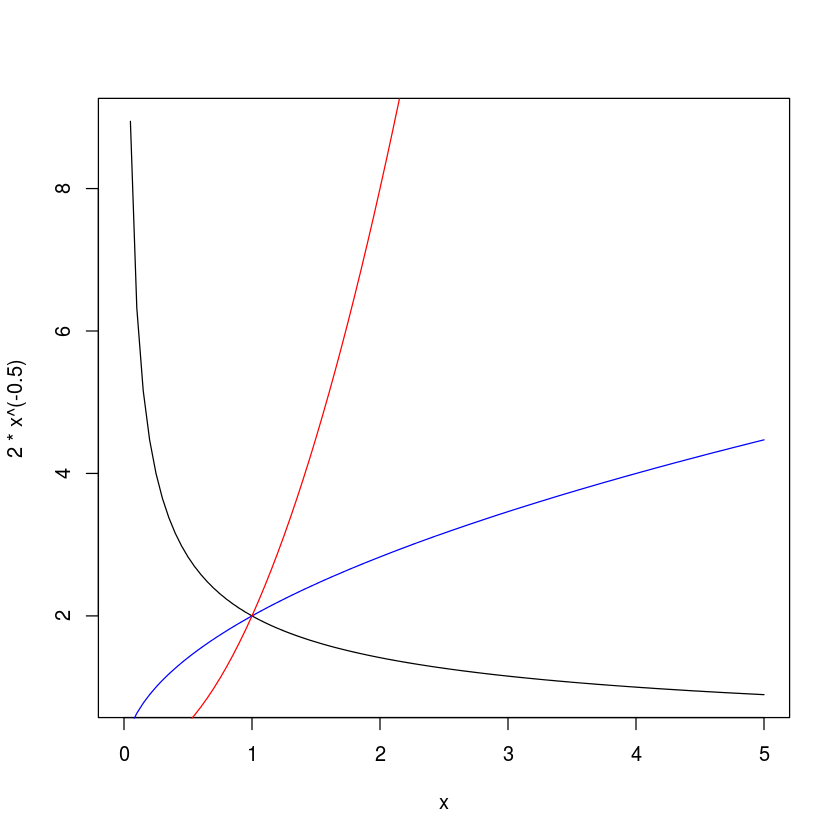

In [8]:
curve(expr = 2*x^(-0.5), from = 0, to = 5, col = "black")
curve(expr = 2*x^(0.5), from = 0, to = 5, col = "blue", add = T)
curve(expr = 2*x^(2), from = 0, to = 5, col = "red", add = T)

### Likelihood
The likelihood of the parameters given the data is equal to the probability of the data given the parameters: $L(\theta | X) = P(X | \theta)$.
Assuming independent, $L(\theta | X_1, X_2) = P(X_1 | \theta)P(X_2 | \theta)$
$$L(\theta | X_1, X_2, \cdots) = \Pi_{i=1}^n P(X_i | \theta)$$

Maximum likelihood: what is the best choice of parameter values, given the data we observe? As the probability is between 0 and 1, multipling many of them will lead to very small values. It is therefore better to work with log maximum likelihood.
$$log(L(\theta | X_1, X_2, \cdots)) = log(\Pi_{i=1}^n P(X_i | \theta)) = \sum_{i=1}^nlog(P(X_i | \theta))$$

For some situations, you can use calculus to derive the formula of the maximum likelihood estimates. But in most cases, it is not possible to write down such formula. In these situations, the MLEs are found using some kind of optimization algorithm (*gradient descent*).

Likelihood ratio test: LR = $2log(L1/L0) ~ \chi^2_{df}$ [assuming large sample size]. To test a single parameter, LR needs to be greater than ~3.84 in order for p < 0.05. For the special case of linear models with normal error, the F-test is a better likelihood ratio test that accounts for sample size. 

The full model will always have a greater likelihood than the restricted model. Why is that? The restricted model is a special case of the full model, where a parameter is no longer free to vary (because θ = 0). Because the full model has an extra free parameter, it will always fit the data a little better, because it has more flexibility in fitting the data. Even if the true value for θ is 0, letting θ be a freely estimated parameter will result in a higher likelihood. Also, the estimates of θ probably will be non-zero due to sampling error. The chi-squared distribution tells us when the difference in likelihoods is large enough that it’s probably not due to sampling error.  

*likelihood curve VS likelihood profile*: A likelihood curve and a likelihood profile are similar but not identical. A likelihood surface says “how does the likelihood vary as I vary some parameter θ, holding any other parameters in the model constant?”. This can be useful for exploring and visualizing how likelihood works. In contrast, to generate a likelihood profile we vary some parameter θ, and for each value of θ we re-fit the model while holding θ at our chosen value.

### Deviance
Doing `summary()` on a glm returns some information about "null deviance" and "residual deviance". The deviance plays a role in generalized linear models that is analogous to the role of sums of squares in linear models, and it is used for residual diagnostics and certain kinds of significance tests. The deviance is defined similar as the likelihood ratio, except now we are comparing the "full" model we are interested in to a "saturated" model that has one parameter for each data point. Adding more parameters to a model will always increase the likelihood of the model, even if those parameters are just fitting noiser rather than real effects (i.e. overfitting).
$$\text{deviance} = 2 \times \text{log}\frac{L(\theta_{saturate} | X)}{L(\theta_{MLE} | X)}$$
The deviance thus is comparing the likelihood of the model we fit $\theta_{MLE}$ to the highest possible likelihood. This is a way to quantify how well the model fits the data, and `summary()` terms the deviance the "residual deviance". For the "null deviance", the saturated model is compared to a model that only has an intercept. So the null deviance basically tells you the upper limit on how poorly a model could fit the data.

Null deviance and residual deviance can be used to calculate pseudo-$R^2$ of GLMs, called "McFadden's": 1 - residual deviance / null deviance. In R, it is `1 - model$deviance/model$null.deviance`.

Raw residules of GLMs are not normaly distributed. For example, residules of Poisson distribution will have large variance with increasing mean. In order to do model diagonostic with residules, residules must be standardized (e.g. accounting for mean-varaince scaling for Poisson models). There are two common ways to do this. 

1. Deviance residuals. It quantifies how much that data point contributes to the model’s overall lack of fit. So if the deviance residual is large, then that data point is relatively far away from its predicted value. The calculation of the likelihoods and deviance automatically accounts for the mean-variance scaling of the Poisson distribution; so for a point to have a large deviance residual, then the point needs to be far from its predicted value, relative to what is expected from the meanvariance scaling. The `residuals()` function in R returns deviance residuals by default
2. Pearson residuals. These account for mean-variance scaling by just dividing the raw residual by the expected standard deviation for that sample. $e_i = (Y_i - \mu_i)/ sd(\mu_i)$. In R, `residuals(model, type = “pearson”)`.

Plotting residuals against fitted values or predictors is a good way to do model diagnostic. To plot, we can use `car::residualPlots()`.

### Overdispersion
The most common and most important issue for GLM fits is *overdispersion*: data show more variance than is expected based on mean-variance scaling (because there are important sources of heterogeneity that are not accounted for in the model). If the data show greater residual variability than is assumed, then confidence intervals and p-values from likelihood ratio tests will be artificially small. In other words, it can substantially increase “false positives” when we are doing hypothesis tests. The magnitude of this effect is directly proportional to how much excess variance there is. Therefore, you can easily detect a lot of spurious effects if you’re using a Poisson model with highly overdispersed data.

We can use *dispersion parameter* to estimate overdispersion: $\varphi = \sum_i^n{e_i^2}/(n - p)$. Here, $e_i$ is the pearson residual, *n* is the number of observations, *p* is the number of paramters in the model. So this is the sum of the squared pearson residuals, divided by the model degrees of freedom. If there is no overdispersion then the dispersion
parameter should be ~1, and a value greater than 1 indicates overdispersion. How big is too big? This is hard to say, and will depend on the situation, but in general the effect is proportional to the square root of the dispersion parameter. So if the φ is 4, then the confidence intervals for the model coefficients will be artificially small by a factor of 2. The rule of thumb suggestions that above 1.5 is too high.

How can we account for overdispersion? Probably the best one is to include predictors in your model that account for the extra variation. Other options include quasi-Poisson, quasi-Binomial etc.

Quasi-Poisson approach says “We don’t know exactly what distribution the data has, but we’ll assume that the variance is proportional to the mean, i.e. V($\mu_i$) = $\varphi\mu_i$”, where φ is the dispersion parameter I defined earlier. So this approach assumes that the distribution is Poisson-like in terms of how the variance changes with the mean, but it allows the variance to be bigger (or smaller) by a factor of φ. This approach is kind of weird because the model-fitting algorithm is similar to what is used for the Poisson, but the model doesn’t actually have a real probability distribution, and therefore doesn’t have a likelihood, which is why this kind of approach is called quasi-likelihood.

The dispersion parameter is estimated as part of fitting the model, and then used to correct any standard errors, confidence intervals, or hypothesis tests. Specifically, the standard errors and confidence intervals from the Poisson model get multiplied by sqrt(φ) to get corrected intervals. Likewise, the likelihood ratio statistic is corrected with φ to get a quantity that has an approximate F-distribution (thus, in R `car::Anova(mod, test = "F")`). Theory shows that the overdispersion doesn’t affect the parameter estimates per se, only the uncertainty around those estimates, and so the quasi-Poisson is a simple and useful approach for count data with excess variance.

The quasi-likelihood approach is convenient, but it has one major downside, which is that we are fitting a model that doesn’t have a real probability distribution. Therefore, no likelihood can be calculated for the fitted model. We can do F-test with the model, but cannot compare models with AIC or likelihood ratio test.

There are two other ways to deal with overdispersion in the Poisson, 1) use negative binomial distribution instead (`MASS::glm.nb()`) so you can use likelihood based model selection (`glm.nb()` will return an estimate of theta, a lower (than one) theta means a greater overdispersion), and 2) use random effects to account for the extra variability. 

#### Using an offset with count data
For count data, one issue that often comes up is that they were made with different sampling effort. For example, if at site one, you sampled 10 quadrats, while at site two, you sampled 30 quadrats, etc. You can convery count data into density data instead of raw count. This will standardize the sampling effort but more challenging to model. To use raw count data in the model when the amount of area/time/effort varies between samples, one can add an **offset** in the model.

In the above example, if we model with Poisson distribution, for site one, $log(\mu) = \cdots$, for site 3, then it is $log(3\mu) = log(3) + log(\mu)$. Here, log(3) is the offset. In R, we can use `glm(y ~ x, offset = log(sample_effort), family = poisson)`

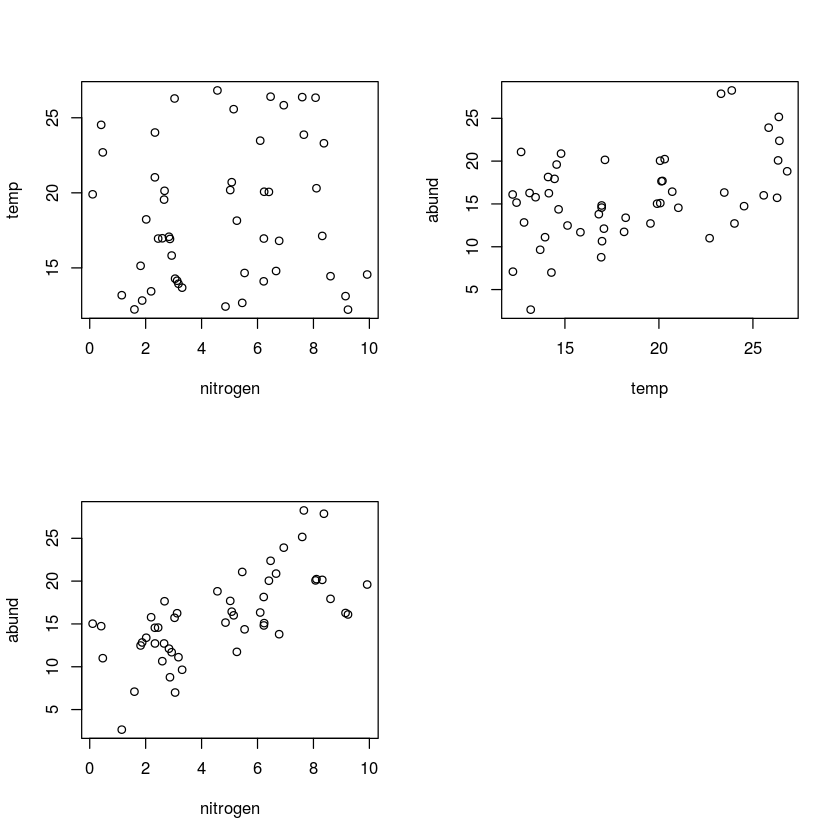

In [24]:
# This example to show the importance of scaling predictors
set.seed(1234)
nitrogen = runif(n = 50, min = 0.01, max = 10)
temp = runif(n = 50, min = 12, max = 28)
abund = 0.5 * temp + 1.3 * nitrogen + rnorm(n = 50, mean = 0, sd = 3)
par(mfrow = c(2, 2))
plot(nitrogen, temp)
plot(temp, abund)
plot(nitrogen, abund)

In [25]:
summary(lm(abund ~  temp * nitrogen))


Call:
lm(formula = abund ~ temp * nitrogen)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8536 -2.0502 -0.5516  1.8644  7.0707 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)    4.15421    3.95881   1.049    0.299
temp           0.31148    0.21455   1.452    0.153
nitrogen       0.73486    0.69842   1.052    0.298
temp:nitrogen  0.02739    0.03735   0.733    0.467

Residual standard error: 3.178 on 46 degrees of freedom
Multiple R-squared:  0.6302,	Adjusted R-squared:  0.6061 
F-statistic: 26.13 on 3 and 46 DF,  p-value: 5.113e-10


In [26]:
summary(lm(abund ~  scale(temp) * scale(nitrogen)))


Call:
lm(formula = abund ~ scale(temp) * scale(nitrogen))

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8536 -2.0502 -0.5516  1.8644  7.0707 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  15.7472     0.4508  34.933  < 2e-16 ***
scale(temp)                   2.0562     0.4611   4.459 5.26e-05 ***
scale(nitrogen)               3.2722     0.4568   7.163 5.19e-09 ***
scale(temp):scale(nitrogen)   0.3373     0.4599   0.733    0.467    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.178 on 46 degrees of freedom
Multiple R-squared:  0.6302,	Adjusted R-squared:  0.6061 
F-statistic: 26.13 on 3 and 46 DF,  p-value: 5.113e-10


In [27]:
summary(lm(abund ~  scale(temp) + scale(nitrogen)))


Call:
lm(formula = abund ~ scale(temp) + scale(nitrogen))

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3380 -2.2087 -0.6987  2.0289  6.9990 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      15.7728     0.4472  35.269  < 2e-16 ***
scale(temp)       2.1096     0.4531   4.656 2.67e-05 ***
scale(nitrogen)   3.2454     0.4531   7.162 4.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.162 on 47 degrees of freedom
Multiple R-squared:  0.6259,	Adjusted R-squared:  0.6099 
F-statistic: 39.31 on 2 and 47 DF,  p-value: 9.249e-11


### Collinearity

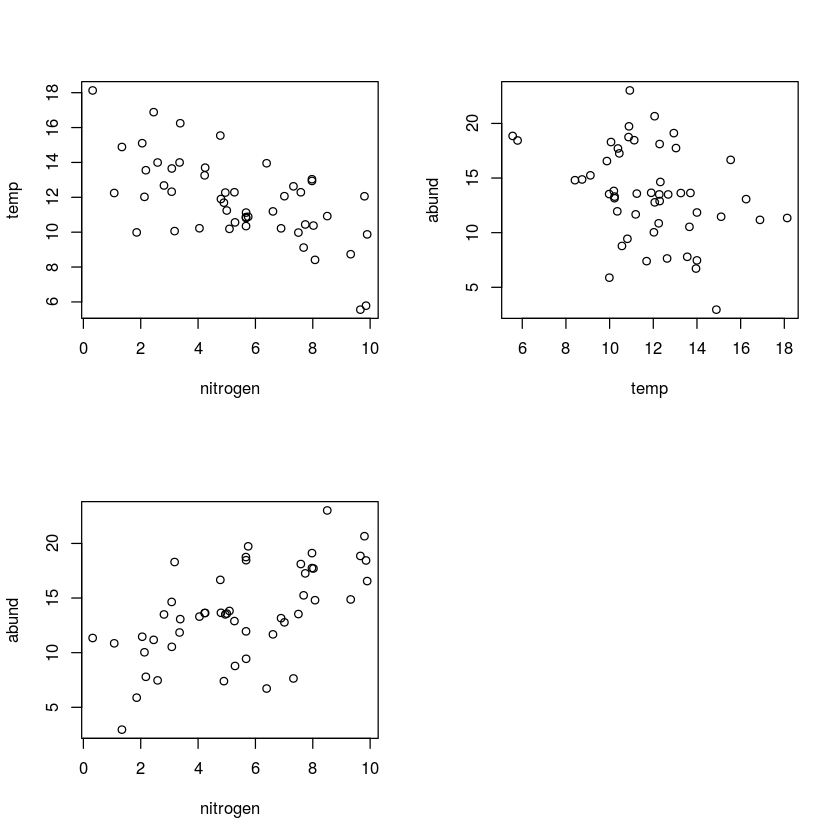

In [28]:
# This example to show the problem of collinearity.
# This example illustrates a challenge of working with observational data, 
# namely that correlated predictors will tend to obscure each other’s effects.
nitrogen = runif(n = 50, min = 0.01, max = 10)
temp = -0.6 * nitrogen + rnorm(n = 50, mean = 15, sd = 2)
abund = 0.5 * temp + 1.3 * nitrogen + rnorm(n = 50, mean = 0, sd = 3)
par(mfrow = c(2, 2))
plot(nitrogen, temp)
plot(temp, abund)
plot(nitrogen, abund)

## Note: abund has NEGATIVE relationship with temp, even the true relationship is POSITIVE. 
## This is because the effect of nitrogen is too strong, compared with those of temp.

In [32]:
summary(lm(abund ~  scale(temp)))


Call:
lm(formula = abund ~ scale(temp))

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8926 -2.1932 -0.0314  2.2681  8.8581 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  13.5609     0.5635  24.067  < 2e-16 ***
scale(temp)  -1.5868     0.5692  -2.788  0.00758 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.984 on 48 degrees of freedom
Multiple R-squared:  0.1394,	Adjusted R-squared:  0.1214 
F-statistic: 7.772 on 1 and 48 DF,  p-value: 0.007581


In [30]:
summary(lm(abund ~  scale(temp) + scale(nitrogen)))
# no relationship with temp (at least not negative...), 


Call:
lm(formula = abund ~ scale(temp) + scale(nitrogen))

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9428 -2.0532  0.4892  1.6627  7.0758 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     13.56094    0.48949  27.704  < 2e-16 ***
scale(temp)      0.09097    0.64346   0.141 0.888176    
scale(nitrogen)  2.62184    0.64346   4.075 0.000176 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.461 on 47 degrees of freedom
Multiple R-squared:  0.364,	Adjusted R-squared:  0.337 
F-statistic: 13.45 on 2 and 47 DF,  p-value: 2.404e-05


The model says that there is a positive effect of nitrogen, and no effect of temperature. So at least we didn’t get a result for temperature that was in the wrong direction, but we also don’t have enough information in the data to estimate the correct temperature effect. However, the multiple regression is still better than a simple regression of abundance vs. temperature, which told us the wrong answer. This example illustrates a challenge of working with observational data, namely that correlated predictors will tend to obscure each other’s effects. To get a more accurate answer we would need to collect data from sites where temperature and nitrogen are more decoupled, or do a manipulated experiment to separate out
the effects of temperature and nitrogen.

It is often inevitable that predictors are somewhat correlated, and if the correlation is not too strong then including multiple predictors will actually yield better results. For example, if temperature and nitrogen are more weakly correlated.

So *general advice* would be: for weak-moderate correlation among predictors, including multiple predictors is OK but keep an eye on whether the results change a lot when predictors are add/removed from the model, and think about what this might be indicating. For strong correlation (e.g., r > 0.7), including multiple predictors is probably going to be problematic. Instead you can do separate analyses with different predictors, and think about what the results mean, or you can combine predictors into composite variables with something like principal coordinates analysis, 

### Logistic regression
Responses are binary data. $Y_i$ = 0 or 1. 
$$\mu_i = \text{logit}^{-1}(\beta_0 + \beta_1X_{1i} + \cdots) = \frac{\text{exp}(\beta_0 + \beta_1X_{1i} + \cdots)}{1 + \text{exp}(\beta_0 + \beta_1X_{1i} + \cdots)}$$
$$\text{logit}(\mu_i) = \beta_0 + \beta_1X_{1i} + \cdots$$
$$Y_i - \text{Binomial}(p = \mu_i, n = 1)$$

$$\text{logit}(\mu_i) = \text{log}(\frac{\mu_i}{1 - \mu_i}) = \text{log}(\frac{P(Y_i = 1)}{P(Y_i = 0)})$$

So we can think of the logit function as the log of the odds, or the log-odds. And then we can interpret the coefficients of the model accordingly. E.g., the meaning of the coefficient $\beta_1$ is “If the predictor $X_1$ increases by one unit, then the log-odds
increases by the amount $\beta_1$”. Equivalently, this means that an increase in $X_1$ by one unit means that the odds (i.e., not on the log scale) is multiplied by a factor of $e^{\beta_1}$.

In general, for binary models (and binomial models in general) it is useful to plot residuals (deviance or Pearson) vs. the predicted values and vs. the individual predictors, to make sure there is no strong patterning.

For binary data, **overdispersion is not possible**. For binary data the distribution only has these two categories, and so the variability in the data is fully determined by the mean $\bar{p}$: var = $\bar{p}(1 - \bar{p})$. Another way of thinking about this is that if the
data has some mean presence $\bar{p}$, then we know the mean absence is $1 − \bar{p}$ . This will not be the case for binomial data with n > 1: var = $n\bar{p}(1 - \bar{p})$.

To fit a binary logistical regression in R `glm(presence ~ X, data = data, family = binomial)`.

Binary data is the special case of the binomial when n = 1. The more general case of the binomial is useful for modeling proportions, specifically proportions where you can say ‘X out of Y’. When it comes to modeling this kind of data, the quantity we want to model is *p*, the probability of ‘success’. So how will the general binomial case differ from the simple binary case? The most important difference is that when the data comes in groups of trials, there is the potential for # of successes to vary among groups in a way that is *overdispersed*. For example, we replicate an experiment 50 times, within each experiment, we measure the number of survivors out of 10 individuals. We plot the histgram of the proportion of survivors in each experiment and we then may see overdispersion.

$$Y_i - \text{Binomial}(p = \mu_i, n = n)$$

To fit a binomial GLM in R: `glm(proportion ~ X, weights = number_trails, data = data, family = binomial)` or `glm(cbind(success, failure) ~ X, data = data, family = binomial)`

For count data we could use the quasipoisson approach for overdispersion, or we could use the negative binomial distribution, which has the advantage of being fit with normal likelihood methods. Is there an analogous distribution to the negative binomial for overdispersed proportion data? There is, and it is called the *beta-binomial distribution*. But for some reason it is not as commonly used as the negative binomial, and requires some less commonly used packages to fit.

### Zero inflation
When we count species at different sites, there are usually many zeros in the data. Why do we care about the extra zeros? Two main reasons. First, zero inflation is a kind of overdispersion, and therefore causes the same problems for confidence intervals and p-values (high false positive, artificial low p-values). Second, if the extra zeros are caused by different processes than the rest of the data, they are going to obscure the effects we are trying to estimate. Separating these components can help reveal the processes driving the counts. And in some cases the processes that cause the extra zeros are interesting in themselves and should be modeled.

Zero-inflated models are *mixture models*. For example, zero-inflated Poisson model has two parts: 

1) Binomial part. There is some binomial probability $\pi_i$ that count *i* is an extra zero that is not produced by Poisson distribution (false zeros). We can use a binomial GLM for this part, i.e. a logistic regression with logit link function. $\text{logit}(\pi_i) = \beta_{00}$.
2) Poisson part. If we do not observe an extra zero, then count *i* is drawn from a Poisson distribution with a probability (1 - $\pi_i$). This draw from Poisson can still produce zero, but it is derived from the Poisson not from binomial trail that represents zero inflation.

In R, we can use `pscl::zeroinfl(y ~ x | 1, dist = "poisson)` to fit the above model. The *x* part is from Poisson while 1 (intercept) is from binomial and is optional. In the following example, for the zero-inflation model part, the coefficient of the intercept is about zero, that means the odd of extra zero and not is about $e^0 = 1$, which is the one we used to simulate the data (1:1). The coefficent of slope for Poisson part is also close to what we used.

However, lots of zeros are not always mean zero inflation (Warton, 2005).

In [41]:
#simulated example of zero inflation problem
set.seed(123)
n = 80
habit = runif(n,0,10)
fish = rpois(n, exp(1 + 0.1*habit))
fish = fish*sample(c(0,1), size = n, replace = TRUE, prob = c(0.5, 0.5)) # half to be extra zeros
# we can try negative binomial, but there are still overdispersion...
summary(pscl::zeroinfl(fish ~ habit | 1, dist = "poisson"))



Call:
pscl::zeroinfl(formula = fish ~ habit | 1, dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.9087 -0.8169 -0.7259  0.8963  2.2212 

Count model coefficients (poisson with log link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.72590    0.20676   3.511 0.000447 ***
habit        0.15097    0.02909   5.191  2.1e-07 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.0155     0.2323  -0.067    0.947
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 12 
Log-likelihood: -133.4 on 3 Df

Procedures:

1. Fit a model with a Poisson distribution, check for overdispersion with pearson residuals or by fitting a quasipoisson or negative binomial model
    + if no overdispersion, good;
    + if overdispersion, go to 2.
2. Because of overdispersion, fit a negative binomial or quasipoisson model.   
3. If you want to test for zero-inflation, fit zero-inflated Poisson model. If still overdispersion there, fit zero-inflated negative binomial model.
4. Compare zero-inflated Poisson model with models without zero-inflation (e.g. negative binomial) with AIC. Because zero-inflated models are mixture models with two probability distribution so LRT cannot be used.

### Transformation
A large proportion of data in biology can be modeled with the normal, Poisson, or binomial distributions (or their overdispersed extensions). However, there are a number of important cases that arise which do not fit easily with any of these distributions.

+ **Positive continuous data**. E.g. size of organisms, gross primary production of ecosystems, etc. These values are all positive and continous, but the distribution is usually smashed against zero and has a long tail of large values (e.g. lognormal distribution). We can log-transfor the data and then use a normal distribution. It would be convenient if the lognormal could be specified in the `glm()` function as well, but there is apparently some debate about whether the lognormal counts as an ‘exponential family’ distribution, and therefore whether this kind of model is a GLM per se, or just looks like a GLM. An alternative to the lognormal is the gamma distribution. These two distributions have a similar shape. But with lognormal is more extensible with mixed models.
+ **Non-negative continous data (with zero)**. E.g. density of plant, etc.  Ideally we could analyze this data using a probability distribution that ranges from zero to infinity and takes on a continuous range of values (the *Tweedie distribution*), but it is difficult to work with because the probability density function does not have a closed formula and has to be quantified using infinite series. Another approach is to assume that the data have been truncated: in reality the density of a species is always positive, but when the density drops below some threshold it is recorded as 0, because we didn’t see any of them in our counts. A simple model for such truncated data is a *Tobit model*.  Two other options: 1) transforming the data, and 2) modeling the zeros separately from the non-zeros.
    - Transforming the data. The general philosophy of modern statistics is to avoid transformation when possible. Classically, transformation was necessary to meet assumptions that 1) the data are normally distributed, and 2) the variance in the data is constant (homoscedasticity). Now that GLMs and extensions have been developed, it is often possible to pick a probability distribution that matches the data well, and this means that models will fit the data better and provide more accurate and sensitive tests of hypotheses. However, situations still arise where there is no appropriate/convenient distribution to use, and transformation is the best option. In general, if there are a small number of zeros then doing a `log(x + small.number)` transformation can work pretty well, but a large proportion of zeros is problematic. Another transformation option is to take the quarter-root of the data (or some other root). The quarter-root is similar to the log transform, in that it spreads out the distance between small values and shrinks the distance between large values. And it has the advantage that the quarter root of 0 is 0, so you can include zeros.
    - Two part conditional model (*hurdle model*). Make a model for positive (presence) and zero (absence) with a binomial GLM; make a second model that only analyzes the positive continous data, with a lognormal distribution, i.e. log-transform and then use lm(). Similar to a zero-inflated model, a two-part model allows for the fact that the zeros may be controlled by different processes than the positive densities. It is also possible to fit a two-part model to discrete count data, though a zero-inflated model usually makes more sense.
        + Modeling this kind of data in two parts is a double-edged sword. On the one hand, it is possible to discover different processes controlling presence/absence vs abundance when present, and the model assumptions are well fit by the data. On the other hand, if presence/absence and abundance are controlled by similar processes, then a two-part model may reduce our ability to detect patterns. The presence-absence model is removing information by converting abundances to presence; the lognormal model is also removing information by dropping the lowest values from the model, thereby reducing the range of the response and also using only half of the data. The best approach will depend on the circumstances and the data. If you really want to fit a single relationship, then something like the quarter-root transform, or a Tweedie or Tobit model is worth considering.
+ **Proportions that are not binomial**. E.g. plant cover within quadrat, percentage of leaf damage, etc. A common recommendation in textbooks is the arcsine square root transformation. Warton and Hui suggest logit transformation: $\text{logit}(x) = \text{log}(x/(1-x))$, which take a value between zero and one and transform it from -infinity to infinity. This function will also tend to ‘stabilize’ the variance, i.e. make it more homoscedastic, by stretching out the distances between values that are near 0 or 1. The only problem is that the logit is undefined when the data equals zero or one. The typical solution is to add a small value to the zeros, and substract a small value from the ones, to make the transformation work. It is possible to model data from 0 to 1 with *beta distribution*. In R, you can use a package called `betareg` to model proportional data with a beta distribution.

|Data type   |Distribution or transformation|
|------|------|
|Continuous, unbounded|Normal distribution|
|Counts|Poisson, negative binomial, quasi-Poisson, zero-inflated P or NB|
|Binary or proportion (X out of Y)|Binomial, quasi-binomial|
|Continuous, > 0|Lognormal, gamma|
|Continuous, ≥ 0|Two-part model; quarter root or log transform; Tweedie; Tobit|
|Non-binomial proportions|arcsin sqrt; Logit transform; beta regression|

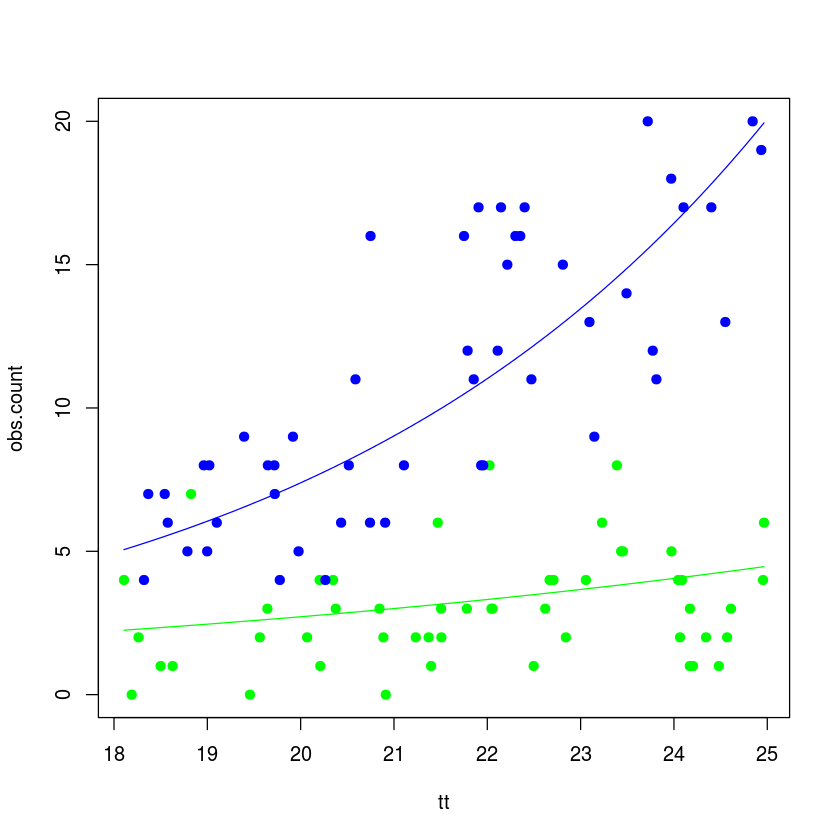

In [51]:
## Simulation of Poisson data
tt = runif(100, min = 18, max = 25)
species = factor(rep(c("a", "b"), each = 50))
intercept.a = -1
intercept.b = -2
slope.a = 0.1
slope.b = 0.2
intercepts = c(intercept.a, intercept.b)[species]
slopes = c(slope.a, slope.b)[species]
predict.count = exp(intercepts + slopes * tt)
obs.count = rpois(length(predict.count), predict.count)
### Each point (random draw) has its own mean...
plot(obs.count ~ tt, col = c("green", "blue")[species], pch = 19)
curve(exp(intercept.a + slope.a * x), col = "green", add = T)
curve(exp(intercept.b + slope.b * x), col = "blue", add = T)

[1] 0.045

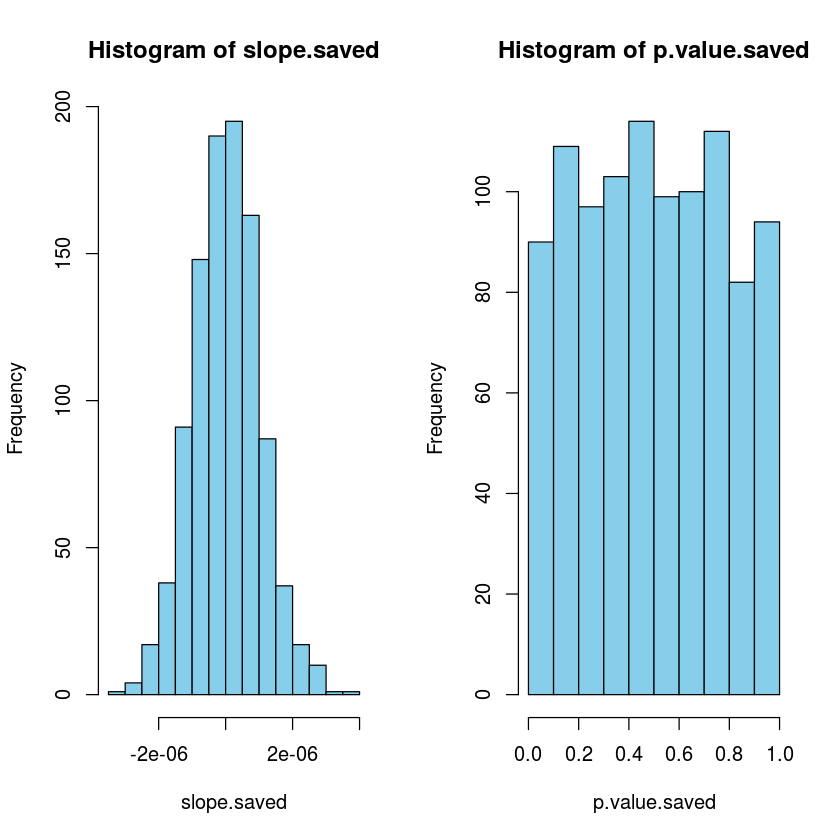

In [56]:
### Type I error
nsims = 1000
sample.size = 30
slope.saved = p.value.saved = vector()
for (i in 1:nsims) {
    set.seed(i)
    gangnam = rnorm(sample.size, mean = 500000, sd = 50000)
    lizards = rpois(sample.size, lambda = 15)

    model = glm(lizards ~ gangnam, family = poisson)
    slope.saved[i] = coef(model)[2]
    p.value.saved[i] = summary(model)$coefficients[2,4]
}
par(mfrow = c(1,2))
hist(slope.saved, col = 'skyblue')
hist(p.value.saved, col = 'skyblue') ## NOTE: uniform distribution of P-values
sum(p.value.saved < 0.05)/nsims

### Cross validation
The $R^2$ of regression models depends on the range of the data. Imaging a model with wide range of X, and there is very strong relationship thus $R^2$ is high. If we just look at a small range of the data, the $R^2$ probably will be very small. This is the total variation of the large range data is much higher.

It would also be great to know how well our models predict new data. We can use *prediction error, RMSE* for this. A model that does a better job of predicting the data will have a lower RMSE.

$$\text{RMSE} = \frac{\sum_i^n(Y_i - \mu_i)^2}{n}$$

Ideally, we can have training data, validation data and testing data. However, if data are scarce, then we can use cross-validation. Common methods include *leave-one-out corss-validation, LOOCV*, *K-fold cross-validation*. The algorithm of LOOCV works like this: 1) Remove a single observation from the dataset. Fit the model with the remaining data, and calculate prediction error $(Y_i - \mu_i)$ for the removed observation. 2) Repeat this process for each observation in the dataset, and calculate the root mean squared prediction error across all iterations. To do the first one on GLM in R, we can use `boot::cv.glm()`. Comparing results from LOOCV and RMSE can give us some insights about overfitting. Cross-validation allows you to estimate how well a model would predict new data. It also provides one way to select among different models and choose the ‘best’, in the sense of best predictive performance. We will see that this is essentially the same thing that AIC does when comparing among models.

### Nonlinear least squares (NLS)
We’ve already been fitting nonlinear curves when we use GLMs, because the link functions are nonlinear. However, these are a special case of nonlinear models, because we are specifying a linear formula for the predictors and then connecting that to the response variable with the nonlinear link function.

NLS： we fit a nonlinear relationship between the response and the predictor(s), and assume the data is normally distributed around the expected value of the response:
$$\mu_i = f(X_{1i}, X_{2i}, \cdots)$$
$$Y_i \sim Guassian(\mu_i, \sigma)$$
*f* here is a nonlinear function, e.g. Michaelis-Menten, functional response. A nonlinear model can be fit with any of the probability distributions we’ve talked about, not just the normal distribution, but fitting nonlinear non-normal models is more complicated and can check Ben Bolker's book for this.
To fit NLS in R, we can use `nls()` function, with specification of the formula for the curve you want to fit. For example, for the Type 2 functional resposes: `nls(y ~ a*x/(1+a*h*x), data, start = list(a = 0.01, b = 0.2))`.

### Model selection
Although stepwise regression based on null hypothese tests and p-values is fairly common, it is much maligned by statisticians. There is no real theoretical framework that explains why this approach should give you the ‘right’ answer, or what the ‘right’ answer means in this context. Using backward or forward selection, or a mix, can give you different ‘best’ models. In addition, the model you get at the end will tend to be overfit, and the degree of overfitting will be more extreme with more predictors to sift through.

However, there are model selection situations (non-nested models, models with many predictors) that are hard to manage in the classic frequentist framework. The most popular alternative is the information theory approach based on AIC.

Information theory is a branch of mathematics invented in the mid-20th century to quantify things like data compression and signal processing. Later it was applied to statistical problems as well, because a statistical model is an approximation of reality in the same way that a low-resolution image is an approximation of a highresolution image. In 1974 Akaike showed that even though we don’t know the true model, we can still quantify the relative information loss of different models.
$$\text{AIC} = -2\text{log}(L(\hat{\theta} | Y)) + 2k$$
This number estimates the relative information loss of different models; in other words, it quantifies how well different models approximate the unknown true model *M*. A smaller AIC indicates a ‘better’ model. AIC can only be used to compare models fit to the same data. It is based on likelihoods, and the likelihoods from different models are only comparable if they are calculated from the same data. AIC is not useful on an absolute scale, only on a relative scale.

AICc can be calculated in R with `MuMIn::AICc()`.

Stone (1977) showed that the ranking of models by AIC is asymptotically equivalent to the ranking of models by leave-one-out cross-validation (LOOCV). Asymptotically means that these two methods are equivalent under very large sample size.

#### Exploring models with many predictors
This is the scenario where we have a bunch of observational data, including a response variable and many potential predictors, and we want to ask “Which of these many predictors has support from the data, and what is their relative importance?”. This case is
challenging because:

+ with many predictors there are many possible models
+ comparing many predictors and many possible models increases the chance of finding spurious results

This kind of analysis is often called ‘exploratory’, as opposed to ‘confirmatory’. This is because we are interested in seeing what patterns are important in the data, rather than testing a specific a priori hypothesis. However, the distinction between exploratory and confirmatory science is usually pretty vague. A controlled experiment with well-defined manipulations, e.g. to test whether adding nitrogen causes plant biomass to increase, is certainly a rigorous test of a predefined hypothesis. But with observational data we often have some hypotheses in mind that we want to test (in an uncontrolled setting), while also being open to any unknown relationships that may emerge from the data.

There are different rules of thumb for how much data you need, relative to the number of parameters in a model. I like to aim for at least 10 samples per parameter, i.e. n/K >= 10. How can we reduce the number of predictors to consider if we have too many predictors, before even making any models?

Reducing correlation among predictors by dropping some predictors would be a win-win, in the sense of avoiding collinearity and also having fewer parameters.

**Five different ways to do a regression with many predictors**:

1. **Just fit one model with all the predictors**. Then we can test the evidence for each predictor from the data using (marginal) likelihood ratio tests (`Anova(model)`).  *Advantages*: By including every predictor of interest in a single model, we bypass the model selection problem, i.e. we don’t have to worry about comparing the support for different models that include/exclude predictors. In addition, we minimize the multiple comparisons problem. *Disadvantages*. One disadvantage, maybe the primary one, is that we don’t have a lot of data in this case, and so including many predictors in a single model may reduce the confidence in the estimates for all of the predictors. We may get much clearer results if we can drop more terms from the model. A second disadvantage is that the effect of one predictor may depend on which other predictors are in the model, due to correlation among the predictors. To see whether this is the case we would need to do some kind of model comparison/selection.
2. **Fit one big model, and drop a few terms that seem unimportant**. *Advantages*: The advantage of starting with a full model and dropping some terms is that with limited data we may get tighter estimates of the remaining terms. *Disadvantages*: By constructing a model, doing significance tests, making a new model, and doing more significance tests, we’ve increased the multiple comparisons problem. Furthermore, by looking for significant terms and refining the model to include those, we are increasing the chance that these effects are spurious, because we’re hunting through the data for any patterns that are there.
3. **Stepwise model selection**. Terms can be added/removed based on LRT results, but the more common approach these days is to use AIC to remove/add terms. The function `step()` in R will take a full model and do backward/forward selection based on whether removing or adding a term decreases AIC. You will often see people combining this with LRTs on the final model `step(big.model); Anova(step.model)`. *Disadvantages*. I can’t really recommend using stepwise model selection, because with modern computational power you can just compare all possible models and find the one with the lowest AIC, if that is your goal. In contrast, stepwise model selection uses an algorithm that may or may not locate the model with the lowest AIC, depending on the data and the details of the algorithm.
4. **Best AIC model**. Compare all possible models, and then select the one has lowest AIC. `MuMIn::dredge(full.model); model.sel(dredge.model)`.
5. Follow 4 and then do LRT on the resulted model.

 Does it really matter which method we use? In my experience, very strong effects will always pop out, and very weak effects will not get any support, regardless of how you construct the model. It’s really the effects with intermediate support that may or may not seem important, depending on how you select the model and which other predictors are in the model. For theoretical/philosophical reasons it’s probably best to avoid 3) stepwise methods, and 5) selecting the best AIC model and then doing null hypothesis tests on it.
 
Personally I prefer to either make one large model and do marginal tests (#1), if I have a lot of data, or look at the full set of models with AIC and evaluate support for predictors across the models (#4C). The former approach avoids too much data snooping, and is consistent with the idea that effects are unlikely to be truly null in most cases. The latter approach acknowledges that if we are comparing many models, we may be uncertain about which is the best. This model selection uncertainty can be quantitatively accounted for using an approach called multimodel inference.

### Generalized additive models
With nonlinear least squares (or an equivalent method for non-normal distributions), we have a particular nonlinear curve that we fit to the data. With additive models we can model nonlinear relationships without specifying a formula for that relationship. Instead we say “let’s assume that Y is some smooth function of X; based on the data, what does that function look like?”. Because we don’t specify a nonlinear function in advance, these methods are called *non-parametric*. In R, we can use `mgcv::gam()` to fit GAMs. To fit quasi-poisson, use `scale = -1` option. Or better to use `family = nb`.

The smooth term reports ‘edf’, which is the estimated degrees of freedom. This number is using the wiggliness of the smooth to say “if this smoother were written as a parametric equation, approximately how many parameters would that equation have”. This number is useful for things like AIC and null hypothesis tests. The F-statistic, and associated p-value, come from an approximate F-test for how (marginal) variation is explained by the smoother. In general one should be a little wary of the p-values returned from this package, because the tests do not account for uncertainty in lambda, the smoother penalty. This tends to make the p-values a little smaller than they should be. We also get output for the deviance explained, the generalized cross-validation score (GCV, the lower the better), etc.

GAMs are one way to account for spatial structure. Specifically, we can just fit a two-dimensional smoother where the predictor variables are latitude and longitude (i.e. `s(lon, lat)`). 

### Linear Mixed Models

- The logic of a random effect is this: rather than fitting a separate parameter for each group, we will assume that the mean density for each group is drawn from a common distribution (a normal distribution). Then the parameters the model estimates are the mean and variance of the underlying distribution, rather than a separate mean for each group. 
- The residual variance is the amount of variation between observations from the same group (note that the model assumes each group has the same within-group variance).
- The maxinmum likelihood estimate for random effect: we treat the value for each group as an unknown quantity, and evaluate the likelihood for all possible values of that quantity. In other words, we say “I don’t know what the value of this group is, and I don’t really want to know, so I will integrate (average) the likelihood calculation across all possible values”. And we will do the same thing for all other groups. So we can think about the process like this: 
    + The likelihood of $Y_i$ depends on the group value
    + But the group value is a random number whose probability depends on µ and σ.
    + So we get a likelihood for the hyperparameters by averaging the probability of observing $Y_i$ for all possible values of hroup means. Becauseof this integration, this is called a marginal likelihood.
- Random effects estimates are often called ‘shrinkage’ estimates, because they will be shrunk towards the overall mean. Andrew Gelman calls this ‘partial pooling’, because the information in the data is partially pooled across groups. The extent of the shrinkage depends on the sample size within each group.
- The `effects` package to extract and visual fixed effects.
- $R^2$ for mixed models is tricky. when we ask “how much variation is explained”, do we mean variation of a particular kind, or ‘all the variation’? And when we get to GLMMs this will be compounded with the fact that $R^2$ is hard to define for non-normal responses. We can calculate an R2 for the total effect of all the predictors on a variance term like this: $1 - \sigma^2_F / \sigma^2_0$ where $\sigma^2_F$ is the variance estimate in the full model, and $\sigma^2_0$ is the variance estimate in the model with no predictors.
- It is also possible to say ‘how much of the total variation is explained by the fixed effects?’, and ‘how much of the total variation is explained by the fixed + random effects?’. These formulas were recently developed by Nakagawa and Scheilzeth and are avaiable in the `MuMln` package.
- Null hypothesis tests for fixed effects: approximate F-test using package `lmerTest`: `anova(lmm,  ddf = "Kenward-Roger")`; parametric boostrap using package `pbkrtest`: `PBmodcomp(full_lmm, nested_lmm)` 
    + In general the Kenward-Roger F-test is usually a fine approach, but when we get to GLMMs we won’t have this option.
- Likelihood ratio tests tend to be anticonservative for fixed effects but tend to be conservative when testing random effects. This means that p-values tend to be too high when testing random effects, leading to reduced power.
- We can’t compare the likelihood of a `lmer` model and an `lm` model that removes the random effect; the reason is that the likelihood is not calculated the same way for the two functions, so you can only compare models fit using the same function. But we can still do a parametric bootstrap, using the package `RLRsim`: `exactRLRT(lmm)`.
- Random effects: how many levels are necessary? When to use fixed instead?
    + The **philosophical** approach. The idea is that using fixed vs. random effects for a grouping factor depends on exactly what you’re interested in. If you’re really interested in comparing particular groups, such as different experimental treatments, or 6 species that you’re comparing, then you should use fixed effects. Random effects are more appropriate when you’re saying ‘I want to quantify variation among these groups, but I’m not particularly interested in individual groups and the differences between them.’ I have been emphasizing the importance of random effects for accounting for nonindependence in the data. In reality fixed and random effects can both do this, but often random effects make more sense.
    + The **pragmatic** approach. It pays attention to how many groups were actually sampled. The issue is that when few groups are sample, the variance among those groups will be poorly estimated

### Generalized least squares
*generalized linear models* are linear-ish model for non-normal data, while **generalized least squares** is a linear model for normally distributed data that includes a residual correlation structure (the residuals are the ‘generalized’ part here).
$$e \sim \text{MultiNormal}(\sigma^2\Sigma)$$
By treating the residuals as a vector drawn from a multivariate distribution, we can explicitly model any correlation among the residuals. This allows us to 1) learn things about the residual correlation structure, and 2) allow a regression model of a time series (or spatial dataset, etc.) to have assumptions that match the nature of the data.

Example R code: `gls(y ~ x, data = data, correlation = corAR1(form = ~ day))`.

In general you should only *compare AIC for models fit using the same function*, because functions can differ in some details of how the log-likelihood is calculated. i.e. to compare with ordinary least squares, use `gls(y ~ x, data = data)`.

It seems like a 2D smoother with GAM might be a good general alternative to using GLS to model spatial autocorrelation. Keep in mind that these two approaches are doing different things: a smoother is modeling variation in the mean of the response, while an autocorrelation model is modeling residual similarity as a function of distance. Nonetheless, it may often be the case that autocorrelation is driven mostly by spatial trends that can be modeled with a GAM.

**Ways to deal with spatial or time series data**  
To sum up, we can compare the different ways you might build a regression model
that is appropriate for spatial or time series data. For spatial data, we have
considered four different possibilities:

1. Use the right predictors. The response variable may be non-independent across space, but the predictors may explain that spatial structure, resulting in residual variation that is spatially uncorrelated.  
2. Model the residual correlation with GLS. If the residual pattern is primarily that closer site are more similar, this will work especially well.   
3. Model the spatial trends with a smoother (GAM). This will not necessarily capture any spatial correlation pattern, but if there are big spatial trends then this will usually work pretty well.  
4. Model space as a set of spatial groups using a mixed model. If you can chunk space into ‘sites’ or ‘regions’, and use a random effect for the spatial groups, this can do a good job of accounting for the fact that nearby observations are similar. This is coarser than the other options, but often simpler to use, especially if you are already using a mixed model. You can check the residuals and random effect estimates to see if there is still strong spatial correlation.

Using these different options will depend on the dataset and your question. In
addition, all of these options can be used for time series as well.

### Ordination
PCA principal components are looking for linear relationships in the data. So if variables in your dataset have nonlinear relationships, these will not be reflected in the analysis. A common approach is to transform the data to make things look more linear before doing PCA; 

Likewise, PCA is all about decomposing the variance in the data, and this makes it sensitive to outliers, which can have a large effect on how much variation an axis explains. These should be evident in biplots, which allows you to remove outliers as a sensitivity analysis.

PCA can be used on environmental or trait data, but usually not the best option for community composition data. The problem is that PCA is a linear technique, but the relationships between species and environmental conditions, and between each other, are often not linear. (e.g. arch effect). We can then think of PCA on community data like this: PC1 is the axis along which the samples have the greatest total dissimilarity. And PC2 is the orthogonal axis along which the samples have the greatest residual dissimilarity, etc. So this is what we’re trying to achieve with ordination, is finding the axes along which the communities show the most variation. But we’ve seen how defining axes in terms of euclidean distance can be problematic (nonlinear responses to environmental gradients; the arch effect). The popular (better) ordination methods improve on PCA by defining dissimilarity
between two community samples with some other number, and using that for the analysis.

The Bray dissimilarity is the default one in `vegan`, and is generally thought to be a
good choice. One important choice for abundance data (as opposed to presenceabsence) is **transformation**. An index like the Bray (and others) is based on how
much abundance differs between sites. This means that a difference between 50
and 100 (e.g. an abundant species) will matter more than a difference between 5
and 10 (e.g. a rare species). Typically when looking at community composition, we
get more sensitive results if each species gets equal ‘weight’. At the same time, it’s a
good idea to drop rare species because they just add noise to the analysis. So, after
dropping an somewhat arbitrary number of species, it is common to transform the
data to put the species on equal footing. Using $log(x + min(x[x>0]))$ is an easy one.
The default in vegan, i.e. if you give an ordination function raw abundance data, is
to first square root transform, and then do a ‘Wisconsin’ standardization, which
divides each species by its maximum abundance (across sites), and then
standardizes sites so that they have the same total abundance `wisconsin(sqrt(comm))`.

You’re starting to see that in order to do ordination, there’s a lot of black magic.
First we (double) transform the data, then we use a dissimilarity coefficient to
summarize how different two samples are. One of the issues with these methods,
which we will return to, is that were don’t actually have a model for the raw data.
In contrast to something like GLMs, where we were trying hard to model the raw
data, in order to get the most sensitive and not-spurious answers.

The dissimilarity matrix is now our ‘data’ for further analysis. Note that the original
species abundances are no longer in the picture; they were used to get the
dissimilarities, but they will not be involved in the next step of the analysis. In order
to use the dissimilarities for ordination, we’re going to *convert these dissimilarities
into spatial distances, by finding axes of variation that show the greatest total
dissimilarity*. This is directly analogous to how PCA works: in that case, we find the
orthogonal axes that account for the most variation in the data, and that variation is
quantified as the euclidean distance. So now instead of using euclidean distance,
we’re going to use some other measure of dissimilarity, and again find orthogonal
axes that account for as much variation as possible.

This method is called *principal coordinates analysis (PCoA)*, and is also known as
*(metric) multidimensional scaling (MDS)*. It is an eigenanalysis method just like
PCA. Once we have our dissimilarity matrix, we find the eigenvectors and
eigenvalues of that matrix, and use those to calculate the ordination. PCoA is somewhat more advantageous for analyses of community composition, relative to PCA, because it can use distance coefficients that are suitable for comparing communities. NMDS is better as it only preserve rank order of dissimilarity, thus allow non-linear relationships.

A common way to see how community composition is related to the environment
is called constrained ordination. The general idea is to find axes in environmental
space that explain as much community variation as possible (Anderson and Willis 2003, Ecology, Canonical analysis of ecological data…). Constrained ordination
becomes useful when we have many dimensions (e.g. many species), and we want
to ask ‘Does variation in this multivariate space correlate with a predictor? How
much variation can be explained by that predictor?’. Because the goal of
constrained ordination is different from the goal of unconstrained ordination, they
will not find the same axes of variation, and so the role of particular predictors may
be obscured in an unconstrained ordination. Commonly used methods
include canonical discriminant analysis, canonical correlation analysis, canonical
correspondence analysis, and redundancy analysis. canonical analysis of principal
coordinates (CAP) is particularly well-suited for community data.

CAP has essentially two steps: 1) Do a PCoA. This allows us to represent the dissimilarity
between community samples in ordination space (i.e., the space defined by the
PCoA axes). We can now use euclidean distance in the ordination space as the
‘response’, to see how well predictors explain multivariate variation. 2) Using the
predictor(s), do an eigenanalysis to find the axis or axes along which the
predictor(s) explain as much of the distance between communities as possible.
Then you can see how much variation is explained by different predictors, plot the
results, etc. In R, use `vegan::capscale()`.

Constrained ordination is great for visualizing how complex multivariate data are
related to one or more predictors. We can do hypothesis tests on
the results, though the method isn’t really designed for hypothesis tests per se. Another method that is probably the best current option for testing the effect of
predictors on a multivariate response is PERMANOVA (`vegan::adonis()`). A complication:
`adonis()` are ‘seqential’ tests of the terms. That means that month is added to the
model first, and its effect is tested, then nitrate is added, and it tests whether nitrate
explains additional variation beyond the effect of month, and then chl is added,
and it is tested whether it explains additional variation, etc. So clearly this is not
ideal, because the results will depend on the order of the terms, especially if the
terms are correlated, as they are here. The only way around this is to run adonis()
multiple times, each time using each variable as the final variable, to get marginal
tests. 

The multivariate methods I’ve covered are widely used, and essentially represent
the state of the art, particularly for analysis of multivariate community data.
However, I personally try to *avoid these methods if possible*, because all of the data
transformation, conversion to dissimilarities, and distance-based analysis of those
similarities makes it hard to understand exactly what you’re getting at the end. Plus
there are the issues with doing valid hypothesis tests that I just mentioned.

#### Mixed models and GAMs as options for multivariate data
If your focus is on seeing how community structure changes as environmental
variables change, or seeing if community structure changes do to an experimental
manipulation, then mixed models are a viable alternative.

In [35]:
library(vegan)
data(varespec)
data(varechem)
# varespec[1:5, 1:5]
# varechem[1:5, 1:5]

# change to long form and then merge both data sets
library(tidyr)
varespec$site = rownames(varespec)
varespec = gather(varespec, key = "sp", value = "abun", -site)
varechem = as.data.frame(scale(varechem))
varechem$site = rownames(varechem)
dat = dplyr::left_join(varespec, varechem, by = "site")
dat$log_abun = log(dat$abun + 0.1)
dat$presence = as.numeric(dat$abun > 0)
head(dat)

,site,sp,abun,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Baresoil,Humdepth,pH,log_abun,presence
1,18,Callvulg,0.55,-0.4673108,-0.1993234,-0.3551562,-0.2063474,0.06197472,-0.419244,-0.8459342,-0.14413,0.2586402,-1.037499,-0.3993382,1.274425,0,-1.09033,-0.4307829,1
2,15,Callvulg,0.67,-1.625036,-0.4000407,0.06740707,-0.874295,-0.4086268,-0.1706973,-0.4445293,-0.1755615,0.09055477,-0.735884,-0.3993382,0.03958974,0,-0.6230455,-0.2613648,1
3,24,Callvulg,0.1,-0.394953,1.513464,0.6812034,1.657091,2.966049,1.791965,-0.03658425,-0.235116,-0.5080651,3.084569,1.684166,-0.1064006,-0.3009172,0.3115227,-1.609438,1
4,27,Callvulg,0,-0.3225952,1.051814,1.091429,1.08521,0.9690408,0.3006844,-1.03887,-0.7479458,2.437852,1.040291,-0.816039,-0.2584739,1.05321,-0.6230455,-2.302585,0
5,23,Callvulg,0,0.2562672,0.630308,0.2725199,0.8512022,0.9349039,0.1978375,-0.9669279,-0.7711059,0.02273085,-0.3337311,-0.3993382,1.402166,1.203669,-1.09033,-2.302585,0
6,19,Callvulg,0,0.07537271,-0.2796103,0.1306373,0.5014226,1.559121,0.309255,-0.3080026,-0.5295796,-0.1689455,0.5040875,0.01736253,1.067605,2.407338,-1.09033,-2.302585,0


In [36]:
# library(lme4)
# mod = glmer(presence ~ N + pH + (1 + N + pH | sp), data = dat, family = binomial)
# summary(mod)
# lattice::dotplot(ranef(mod, condVar = T))

The key point here is that we can use the random effect for season to quantify how much community composition changes along N gradient. If this random effect is nonzero, that means that species change in relative abundance with N. And the larger the effect is, the more composition changes. The upshot of this approach is that we can see the species-specific responses more clearly, while getting at the same scientific question. The downside is that if we want to use continuous environmental predictors, we need to assume the effects of
those predictors are linear. Often this is roughly true anyways. If responses are
strongly nonlinear, an alternative approach is to fit a GAM, where the smoother
varies by species.

### Bayes
Bayes' rule: $$P(A|B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B|A)P(A)}{P(B)}$$

The innovation of bayesian statisticians (actually, the innovation of Laplace, who rediscovered and extended Bayes’ work) is to use Bayes’ rule to talk about the *probability of hypotheses*, or equivalently, the probability that a parameter has a particular value.

Frequentist define probability by *iterating a process many many times* and then calculate how many times a event happended. Or *data has a probability, hyptheses do not; assume the hypothesis is true, what is the chance to get at least as extreme as the observed data?*

In contrast, Bayesian approach asks: *given the data observed, what is the probability of a hypothesis?* $$P(\text{Hypothesis} | \text{data}) \propto P(\text{data} | \text{Hypothesis})P(\text{Hypothesis})$$ or $$\text{Posterior} \propto \text{Likelihood} \times \text{Prior}$$

**Frequentist interval**: over many iterations of the sampling process, the 95% CI will
contain the true value of the slope 95% of the time.

**Bayesian interval**: there is a 95% probability that the parameter lies in this interval, often called *credible intervals*.